Build a regression model.

In [35]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import sqlite3 as sqlite


In [36]:
#Connect to database to create DF
connection = sqlite.connect('../data/bike_foursquare.db')

#Create DataFrame from SQL DB
places_df = pd.DataFrame(pd.read_sql('SELECT * FROM places', connection))
places_df


,id,name,latitude,longitude,bike_slots,public_art,night_club,bicycle_store,coffee_shop,fast_food,museum,grocery_store,total_poi
0,00fa94ad698dc4a9e4d708d6fd32f294,Chilco & Barclay,49.291909,-123.140713,18,0,1,5,16,14,1,11,48
1,012d3e06901cc222b1c2cf0a2ace3a29,St George & Broadway,49.262321,-123.093060,14,1,2,1,10,3,0,8,25
2,029a505bd4422a1afd127987757f71a6,Britannia Parking Lot,49.275882,-123.071865,14,0,1,4,21,1,0,12,39
3,0438114d2e6b96118de69bc9775bb21e,Morton & Denman,49.288030,-123.142135,26,1,1,1,16,11,0,8,38
4,0459b7e93703980b853cd65a9dc60596,Thornton & National,49.273777,-123.092723,14,0,0,0,7,4,0,11,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,f90ed7ad754ec04b7852941a480a4c77,Balaclava & 6th,49.266924,-123.173849,16,0,0,3,19,8,0,9,39
213,fad9ebcf614dd1a72593a34072ff76f8,Helmcken & Burrard,49.279938,-123.127478,15,0,27,5,44,41,1,23,141
214,fbb4c06b719596c21f91fd51ef6d4710,7th & Heather,49.265089,-123.119425,18,1,0,2,29,9,0,5,46
215,fe0c57d04d6e682d284d501446095fc9,Union & Dunlevy,49.277595,-123.095830,16,0,1,2,21,8,2,30,64


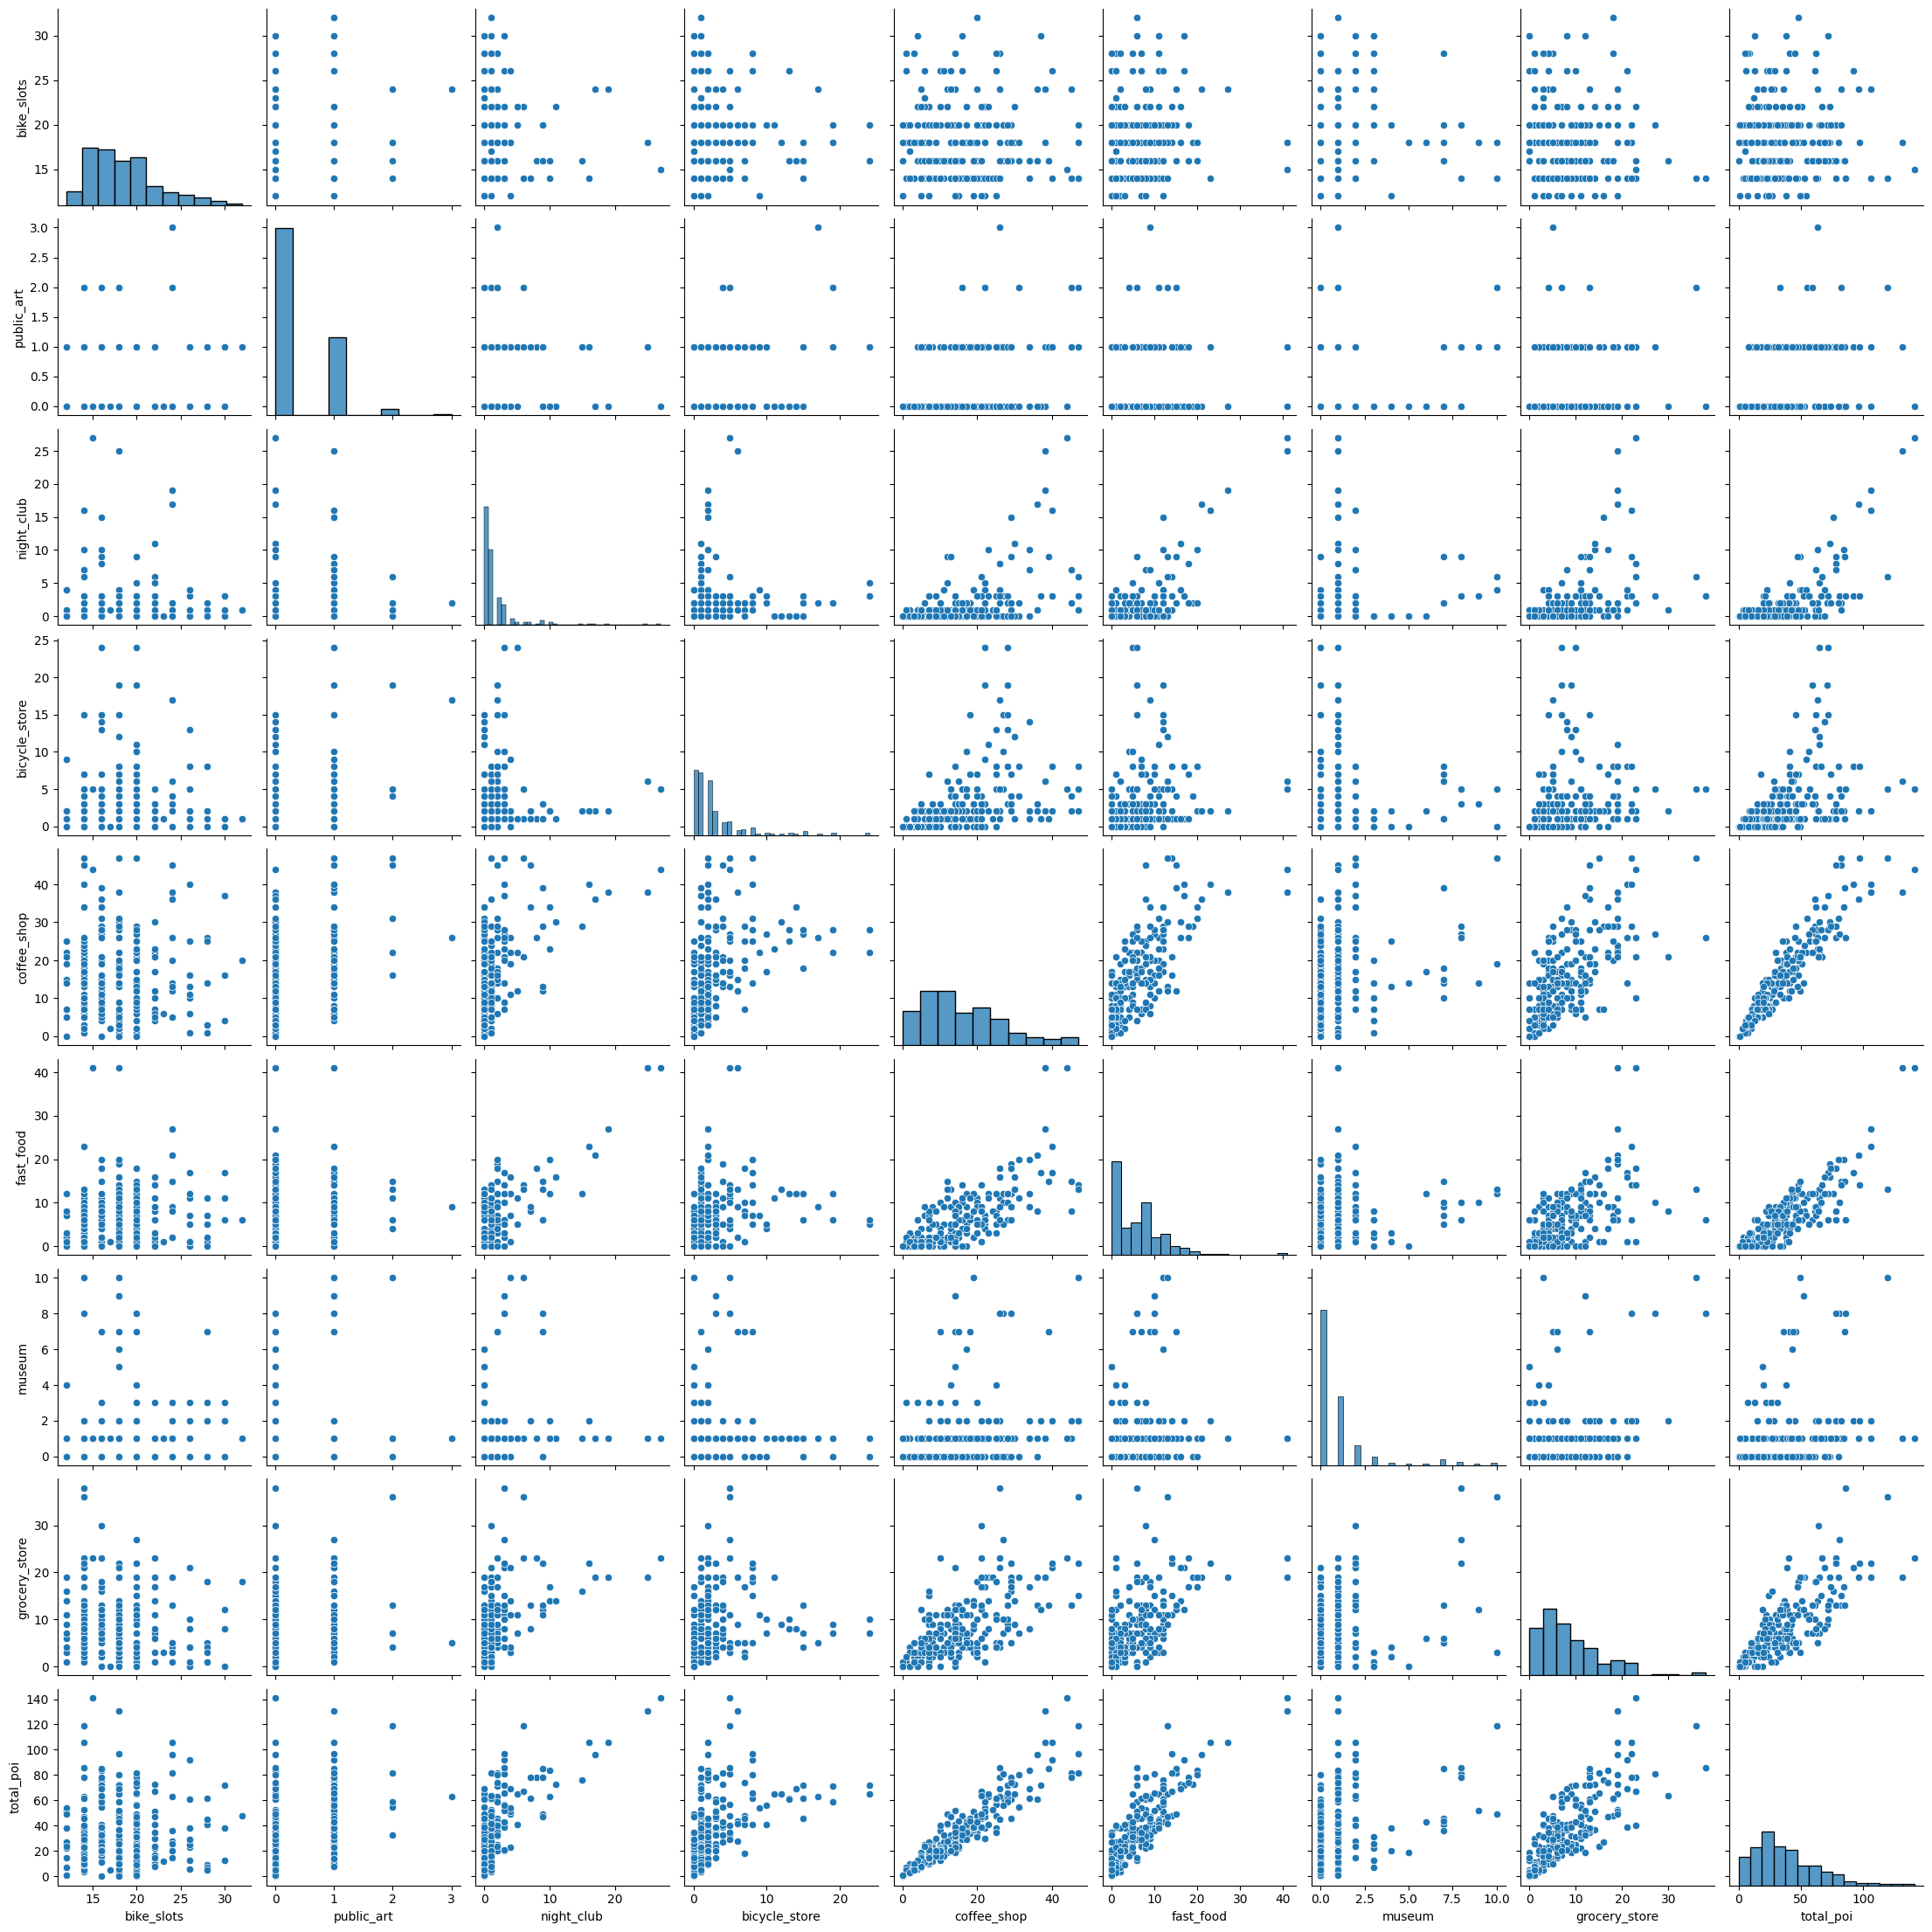

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

#Drop latitude and longitude from DF
places_df = places_df.drop(columns=['latitude', 'longitude'])

#Set index as station 'name'
places_df.index = places_df['name']

sns.pairplot(data=places_df)

In [48]:
places_df.corr(numeric_only=True)

,bike_slots,public_art,night_club,bicycle_store,coffee_shop,fast_food,museum,grocery_store,total_poi
bike_slots,1.000000,0.005235,0.022098,0.059016,0.029595,0.085282,0.122576,-0.073707,0.035127
public_art,0.005235,1.000000,0.159727,0.350379,0.382875,0.239749,0.109593,0.146936,0.363120
night_club,0.022098,0.159727,1.000000,0.090585,0.519784,0.713277,0.175113,0.465825,0.685550
bicycle_store,0.059016,0.350379,0.090585,1.000000,0.428124,0.265287,0.057388,0.181512,0.472660
coffee_shop,0.029595,0.382875,0.519784,0.428124,1.000000,0.727977,0.251421,0.642009,0.928682
fast_food,0.085282,0.239749,0.713277,0.265287,0.727977,1.000000,0.174522,0.546547,0.850089
museum,0.122576,0.109593,0.175113,0.057388,0.251421,0.174522,1.000000,0.237607,0.318960
grocery_store,-0.073707,0.146936,0.465825,0.181512,0.642009,0.546547,0.237607,1.000000,0.777841
total_poi,0.035127,0.363120,0.685550,0.472660,0.928682,0.850089,0.318960,0.777841,1.000000


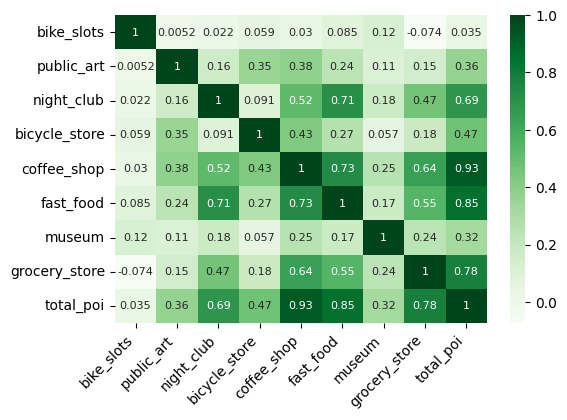

In [56]:
#Setup numeric only dataframe
numeric_df = places_df.select_dtypes(include=[np.number])

#Setup figures details
plt.figure(figsize=(6, 4))
sns.heatmap(numeric_df.corr(), cmap='Greens', annot=True, annot_kws={'fontsize': 8})
plt.xticks(rotation=45, ha='right')
plt.show()

Provide model output and an interpretation of the results. 

In [47]:
#Check if correlations are significant on interesting relations (if <0.05 then relationship is significant)
import scipy

remaining_places_df = places_df.drop(columns=['id', 'name', 'bike_slots'])
remaining_columns = remaining_places_df.columns
print(remaining_columns)

for category in remaining_columns:
    stats, p1 = scipy.stats.pearsonr(places_df['bike_slots'], places_df[category])
    print(f"Bike Slots vs {category}: {p1}")

Index(['public_art', 'night_club', 'bicycle_store', 'coffee_shop', 'fast_food',
       'museum', 'grocery_store', 'total_poi'],
      dtype='object')
Bike Slots vs public_art: 0.9388829403769059
Bike Slots vs night_club: 0.7461746877142382
Bike Slots vs bicycle_store: 0.38698804005646337
Bike Slots vs coffee_shop: 0.6646287762709836
Bike Slots vs fast_food: 0.21082060935991895
Bike Slots vs museum: 0.07154051991244911
Bike Slots vs grocery_store: 0.279709464885841
Bike Slots vs total_poi: 0.6068128337994991


All p-values are >0.05, so we can conclude that there are **no significant correlations between bike slots and points of interest**. 

## Attempt to find other correlations we can model

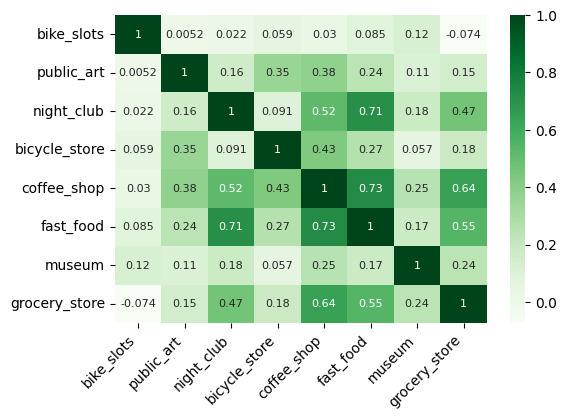

In [57]:
#Setup numeric only dataframe
numeric_df = places_df.select_dtypes(include=[np.number])

#Drop total_poi column as undesired
numeric_df = numeric_df.drop(columns='total_poi')

#Setup figures details
plt.figure(figsize=(6, 4))
sns.heatmap(numeric_df.corr(), cmap='Greens', annot=True, annot_kws={'fontsize': 8})
plt.xticks(rotation=45, ha='right')
plt.show()

In [133]:
#Predicting FAST FOOD locations
#Check if correlations are significant on interesting relations (if <0.05 then relationship is significant)

#Drop columns we do not want to test. total_poi is dropped because it is dependant on other variables.
remaining_places_df = places_df.drop(columns=['id', 'name', 'bike_slots', 'fast_food', 'total_poi'])

remaining_columns = remaining_places_df.columns
print(remaining_columns)

for category in remaining_columns:
    stats, p1 = scipy.stats.pearsonr(places_df['fast_food'], places_df[category])
    print(f"Fast Food vs {category}: {p1}")

Index(['public_art', 'night_club', 'bicycle_store', 'coffee_shop', 'museum',
       'grocery_store'],
      dtype='object')
Fast Food vs public_art: 0.00036603978742717893
Fast Food vs night_club: 4.940528814695985e-35
Fast Food vs bicycle_store: 7.606271466745094e-05
Fast Food vs coffee_shop: 4.2343640834865e-37
Fast Food vs museum: 0.01000017891343023
Fast Food vs grocery_store: 2.6715463607069685e-18


Many Pearson correlation coeeficients are <0.05 indicating potentially significant correlations

In [134]:
#Setup table for simple linear regression

#Dependant variable
y = places_df['fast_food']

#Create list of independant variables with constants to use for model evaluation
X = [sm.add_constant(remaining_places_df[category]) for category in remaining_places_df]

print(f"{remaining_columns}")

X[3].head(10)

Index(['public_art', 'night_club', 'bicycle_store', 'coffee_shop', 'museum',
       'grocery_store'],
      dtype='object')


,const,coffee_shop
name,,
Chilco & Barclay,1.0,16
St George & Broadway,1.0,10
Britannia Parking Lot,1.0,21
Morton & Denman,1.0,16
Thornton & National,1.0,7
Burrard & 14th,1.0,5
Olympic Village Station,1.0,25
8th & Macdonald,1.0,21
30th & Ontario,1.0,7


In [135]:
#Create model for one independant variable
model = sm.OLS(y, X[3])
results = model.fit()
adj_r2 = results.rsquared_adj
p_value = results.pvalues
print(f"adj.R2: {adj_r2}, p_value: {p_value}")
print(results.summary())

adj.R2: 0.5277641115558327, p_value: const          5.830321e-01
coffee_shop    4.234364e-37
dtype: float64
                            OLS Regression Results                            
Dep. Variable:              fast_food   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     242.4
Date:                Thu, 23 Jan 2025   Prob (F-statistic):           4.23e-37
Time:                        20:15:32   Log-Likelihood:                -623.28
No. Observations:                 217   AIC:                             1251.
Df Residuals:                     215   BIC:                             1257.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------

In [136]:
#Create output for all independant variables
models_list = [sm.OLS(y, x) for x in X]
results_list = [model.fit() for model in models_list]
adj_r2_list = [result.rsquared_adj for result in results_list]
p_value_list = [result.pvalues for result in results_list]

#Loop through all results in lists and print to inspect which ones will be useful
for i in range(len(adj_r2_list)):
    
    current_column = remaining_columns[i]
    current_adj_r2 = adj_r2_list[i]
    current_pvalue = p_value_list[i].iloc[1]*100

    print(f"{current_column}: adj_r2 = {current_adj_r2:.3f}, p-value = {current_pvalue:.5f}%")

public_art: adj_r2 = 0.053, p-value = 0.03660%
night_club: adj_r2 = 0.506, p-value = 0.00000%
bicycle_store: adj_r2 = 0.066, p-value = 0.00761%
coffee_shop: adj_r2 = 0.528, p-value = 0.00000%
museum: adj_r2 = 0.026, p-value = 1.00002%
grocery_store: adj_r2 = 0.295, p-value = 0.00000%


## Select independant variables to use to find adjusted r-squared values

Create function to output results as we will run this repeatedly until we find the best fit

In [165]:
#Create function to output model results
def export_model_results(full_dataframe, columns_to_include, show_excluded=True):
    
    included_df = full_dataframe[columns_to_include]
    included_df_w_constant =  sm.add_constant(included_df)
    excluded_df = full_dataframe.drop(columns_to_include, axis=1)

    # included_df_w_constant

     #Create model for chosen places
    model = sm.OLS(y, included_df_w_constant)
    results = model.fit()
    adj_r2 = results.rsquared_adj
    p_value = results.pvalues
    print(f"adj.R2: {adj_r2}, p_value: {p_value}")
    print(results.summary())

    #Output stats for excluded columns

    #Create list of independant variables with constants to use for model evaluation    
    X = [sm.add_constant(excluded_df[item]) for item in excluded_df] 
    excluded_columns = excluded_df.columns

    if show_excluded:

        #Create output for all excluded independant variables
        models_list = [sm.OLS(y, x) for x in X]
        results_list = [model.fit() for model in models_list]
        adj_r2_list = [result.rsquared_adj for result in results_list]
        p_value_list = [result.pvalues for result in results_list]

        print("\n\n::EXCLUDED COLUMNS w/ p-values & adjusted r2::")
        for i in range(len(adj_r2_list)):
            current_column = excluded_columns[i]
            current_adj_r2 = adj_r2_list[i]
            current_pvalue = p_value_list[i].iloc[1]*100

            print(f"{current_column}: adj_r2 = {current_adj_r2:.3f}, p-value = {current_pvalue:.5f}%")
        


In [162]:
included_df = remaining_places_df[['night_club']]
included_df_w_constant =  [sm.add_constant(included_df)]

included_df_w_constant

[                       const  night_club
 name                                    
 Chilco & Barclay         1.0           1
 St George & Broadway     1.0           2
 Britannia Parking Lot    1.0           1
 Morton & Denman          1.0           1
 Thornton & National      1.0           0
 ...                      ...         ...
 Balaclava & 6th          1.0           0
 Helmcken & Burrard       1.0          27
 7th & Heather            1.0           0
 Union & Dunlevy          1.0           1
 8th & Prince Edward      1.0           3
 
 [217 rows x 2 columns]]

### Create base model with one independant variable
This will set a baseline for which to work and allow us to add new variables to see if it gets better or worse

In [166]:
places_to_include = ['night_club']
export_model_results(remaining_places_df, places_to_include)

adj.R2: 0.506478841047973, p_value: const         2.402066e-28
night_club    4.940529e-35
dtype: float64
                            OLS Regression Results                            
Dep. Variable:              fast_food   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     222.7
Date:                Thu, 23 Jan 2025   Prob (F-statistic):           4.94e-35
Time:                        20:35:29   Log-Likelihood:                -628.06
No. Observations:                 217   AIC:                             1260.
Df Residuals:                     215   BIC:                             1267.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

The results above for 'night_club' has an adjust r2 of 0.509. We will add another variable to see if it gets better

In [169]:
places_to_include = ['night_club', 'coffee_shop']
export_model_results(remaining_places_df, places_to_include)

adj.R2: 0.6806588800315665, p_value: const          2.447096e-01
night_club     3.789469e-20
coffee_shop    3.249965e-22
dtype: float64
                            OLS Regression Results                            
Dep. Variable:              fast_food   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     231.2
Date:                Thu, 23 Jan 2025   Prob (F-statistic):           3.33e-54
Time:                        20:37:48   Log-Likelihood:                -580.33
No. Observations:                 217   AIC:                             1167.
Df Residuals:                     214   BIC:                             1177.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0

With 2 independant variables we have a much higher r-squared of 0.684! Let's add another to see the results.

In [170]:
places_to_include = ['night_club', 'coffee_shop', 'public_art']
export_model_results(remaining_places_df, places_to_include)

adj.R2: 0.6796824222019402, p_value: const          2.390935e-01
night_club     5.841728e-20
coffee_shop    1.262447e-20
public_art     5.560763e-01
dtype: float64
                            OLS Regression Results                            
Dep. Variable:              fast_food   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     153.8
Date:                Thu, 23 Jan 2025   Prob (F-statistic):           4.83e-53
Time:                        20:38:08   Log-Likelihood:                -580.15
No. Observations:                 217   AIC:                             1168.
Df Residuals:                     213   BIC:                             1182.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t  

Adding 'public_art' has not increased the r-squared, so it can be omittted. We will try a few more

In [171]:
places_to_include = ['night_club', 'coffee_shop', 'grocery_store', 'bicycle_store']
export_model_results(remaining_places_df, places_to_include)

adj.R2: 0.6786199861730813, p_value: const            3.362084e-01
night_club       6.655794e-19
coffee_shop      3.320339e-13
grocery_store    4.927310e-01
bicycle_store    6.305536e-01
dtype: float64
                            OLS Regression Results                            
Dep. Variable:              fast_food   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     115.0
Date:                Thu, 23 Jan 2025   Prob (F-statistic):           5.63e-52
Time:                        20:38:13   Log-Likelihood:                -580.00
No. Observations:                 217   AIC:                             1170.
Df Residuals:                     212   BIC:                             1187.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
        

Adding more variables has not increased the efficiency of the model, but rather penalized the model for having more variables. 

## Results

The best model to predict the number of **fast food* restaurants within 500m of a bike shops is
`fast_food_restaurants = 0.51 + (0.75 * night_club) + (0.31 * coffee_shop)`

In [172]:
#Return to best fit model
places_to_include = ['night_club', 'coffee_shop']
export_model_results(remaining_places_df, places_to_include, show_excluded=False)

adj.R2: 0.6806588800315665, p_value: const          2.447096e-01
night_club     3.789469e-20
coffee_shop    3.249965e-22
dtype: float64
                            OLS Regression Results                            
Dep. Variable:              fast_food   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     231.2
Date:                Thu, 23 Jan 2025   Prob (F-statistic):           3.33e-54
Time:                        20:38:22   Log-Likelihood:                -580.33
No. Observations:                 217   AIC:                             1167.
Df Residuals:                     214   BIC:                             1177.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0

# Stretch

How can you turn the regression model into a classification model?